In [1]:
import datetime
import pytz
import glob
import re

import numpy as np
import pandas as pd

import pylab
from colour import Color
from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from bigbang import listserv
from bigbang.analysis.listserv import ListservArchive
from bigbang.analysis.listserv import ListservList
from bigbang.visualisation import stackedareachart
from bigbang.visualisation import lines
from bigbang.visualisation import utils
from bigbang.analysis.utils import (
    get_index_of_msgs_with_subject,
    get_index_of_msgs_with_datetime,
)

In [2]:
mlist_name = "3GPP_TSG_RAN_WG3"
filepath = f"path_to_bigbang/archives/3GPP/{mlist_name}.h5"  # change this to your own folder structure
df = pd.read_hdf(filepath, "df")

mlist = ListservList.from_pandas_dataframe(
    df=df,
    name=mlist_name,
    filepath=filepath,
)
mlist.df = mlist.df[mlist.df["thread"].notna()]
mask = get_index_of_msgs_with_datetime(mlist.df, return_boolmask=True)
mlist.df = mlist.df.loc[mask]

# Entities in Focus
eois = [
    "huawei.com",
    "huawei.comcc",
    "tencent.com",
    "xiaomi.com",
    "chinamobile.com",
    "hisilicon.comzte.com.cn",
    "chinatelecom.cn",
    "chinaunicom.cn",
    "catt.cn",
    "caict.ac.cn",
]

In [3]:
standard_release_info = pd.read_csv(
    "path_to_bigbang/bigbang/analysis/3GPP_standards_release_dates.csv",  # change this to your own folder structure
    sep=",",
    header=2,
    index_col=False,
)
standard_release_info["Start date"] = pd.to_datetime(
    standard_release_info["Start date"], format="%Y-%m-%d"
)
standard_release_year = [dt.year for dt in standard_release_info["Start date"]]

In [4]:
period_of_activity = mlist.period_of_activity()
years = [dt.year for dt in period_of_activity]
years = np.arange(min(years), max(years) + 1)
dics = {yr: {} for yr in years}

thread_nrs = np.unique(mlist.df["thread"].values)

count = 0
for tnr in thread_nrs:
    _df = mlist.df[mlist.df["thread"] == tnr]
    start_year = _df["date"].min().year

    _df_first = _df[_df["date"] == _df["date"].min()]
    _, _, domain = ListservList.get_name_localpart_domain(_df_first["from"].values[0])

    if domain in list(dics[start_year].keys()):
        dics[start_year][domain] += [len(_df.index.values)]
    else:
        dics[start_year][domain] = [len(_df.index.values)]

# averaging
for yr, val1 in dics.items():
    for do, val2 in val1.items():
        dics[yr][do] = np.mean(val2)

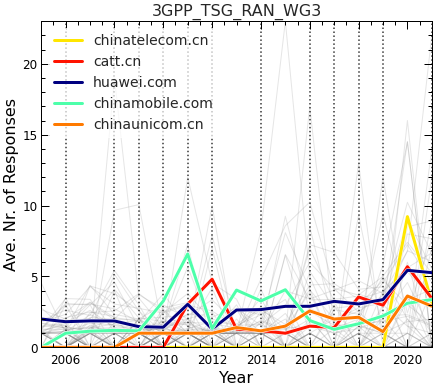

In [5]:
fig, axis = plt.subplots(
    1,
    1,
    figsize=(7, 6),
    # sharex=True, sharey='row',
    # gridspec_kw={'height_ratios': [2, 1]},
    facecolor="w",
    edgecolor="k",
)
lines.evolution_of_participation_1D(
    dics,
    ax=axis,
    entity_in_focus=eois,
    percentage=False,
)

for yr in standard_release_year:
    axis.axvline(x=yr, linestyle=":", color="k", alpha=0.8, zorder=0)

axis.set_xlim(2005, 2021)

axis.set_title(mlist_name)
axis.set_xlabel("Year")
axis.set_ylabel("Ave. Nr. of Responses")
axis.legend(loc=2, edgecolor="white", facecolor="white", framealpha=0.7)

# """
plt.savefig(
    f"responsivity_ave_nr_of_repl_{mlist_name}.png",
    format="png",
    transparent=True,
    dpi=300,
    bbox_inches="tight",
)  # """